### Script pour interpreter les résultats du benchmark

In [1]:
import matplotlib 
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import cv2
import json
from random import randint
from math import cos,sin,atan,sqrt
from glob import glob

In [2]:
def carte(matched,positions,vt,meta):
    
    fresque = cv2.imread(meta['base_dir']+'fresque_small{}.ppm'.format(meta['fresque_id']))
    
    fig,ax = plt.subplots()
    ax.imshow(fresque)
    for i in range(len(matched)):
        if(matched[i]==1):
            #ax.arrow(vt[i][0],vt[i][1],p[i][0]-vt[i][0],p[i][1]-vt[i][1])
            ax.plot([vt[i][0],p[i][0]],[vt[i][1],p[i][1]],marker='D',color='red')
            ax.plot([vt[i][0]],[vt[i][1]],marker='D',color='green')
    fig.show()
    
def correlation(matched, position, vt, d, meta):
    
    fig,ax = plt.subplots()
    for i in range(len(matched)):
        if matched[i] == 1:
            frag = cv2.imread('{}/fragments/fresque{}/frag_bench_{:05}.ppm'.format(meta['base_dir'],meta['fresque_id'],i))
            ax.scatter(frag.shape[1],frag.shape[0],s=d[i]*2,alpha=0.5)
    ax.set_xlabel("Width")
    ax.set_ylabel('Height')
    ax.set_title("Erreur de placement en fonction de la hauteur et la largeur des fragments.")
    fig.show()
    
def distance_vecteur(matched,p,v):
    
    fig, ax = plt.subplots()
    for i in range(len(matched)):
        if matched[i] == 1:
            vecteur = (v[i][0]-p[i][0],v[i][1]-p[i][1])
            #print('{}:{} {}:{}'.format(v[i][0], v[i][1], vecteur[0], vecteur[1]))
            #ax.arrow(0,0,vecteur[0],vecteur[1])
            ax.scatter(vecteur[0],vecteur[1],s = (vecteur[0]**2+vecteur[1]**2)**0.5)
            
    ax.set_xlabel("W")
    ax.set_ylabel('H')
    ax.set_title("Vecteur d'erreur de placement.")
    fig.show()
    
def correl_pos_err(matched,p,d):
    
    fig, ax = plt.subplots()
    for i in range(len(matched)):
        if matched[i] == 1:
            ax.scatter(p[i][0],p[i][1],s = d[i]*10)
            
    ax.set_xlabel("W")
    ax.set_ylabel('H')
    ax.set_title("Erreur de placement en fonction de l'emplacement.")
    plt.gca().invert_yaxis()
    fig.show()

def dist_dist(m,p,d):
    
    ab,ordo = [],[]
    fig,ax = plt.subplots()
    
    for i in range(len(m)):
        if m[i] == 1:
            ax.scatter(sqrt(p[i][0]**2+p[i][1]**2),d[i])
            ab.append(sqrt(p[i][0]**2+p[i][1]**2))
            ordo.append(d[i])
    ax.set_xlabel("Distance à l'origine")
    ax.set_ylabel("Erreur, distance à la verité terrain")
    ax.set_title("Erreur en fonction de la distance à l'origine")
    fig.savefig("correl_post_backtrack.pdf")
    fig.show()
    
    
    A = np.vstack([ab, np.ones(len(ab))]).T
    print(A.shape)
    m, c = np.linalg.lstsq(A, np.array(ordo), rcond=None)[0]
    print("m: {}, c:{}".format(m,c))
    
def rectification(pos,m,c):
    npos = [0,0,pos[2]]
    err = m*sqrt(pos[0]**2+pos[1]**2)+c
    alpha = atan(pos[0]/pos[1])
    
    npos[0] = pos[0] + sin(alpha)*err
    npos[1] = pos[1] + cos(alpha)*err
    
    return(npos)

def barchart(d):
    fig, ax = plt.subplots()
    
    intd = [int(dist) for dist in d if(dist>0)]
    
    bars = [intd.count(i) for i in range(max(intd)+1)]
    ab = np.arange(0,len(bars),1)
    
    ax.bar(ab,bars)
    
    fig.show()
            
def barchart_dif(d,nd):
    fig, ax = plt.subplots()
    
    intd = [int(dist) for dist in d if(dist>0)]
    intnd = [int(dist) for dist in nd if(dist>0)]
    
    bars = [intd.count(i) for i in range(max(intd)+1)]
    nbars = [intnd.count(i) for i in range(max(intnd)+1)]
    
    ab = np.arange(0,len(bars),1)
    nab = np.arange(0,len(nbars),1)
    
    offset = 0.25
    width = 0.25
    
    ax.bar(ab,bars,width=width,color='teal',label='Erreurs')
    ax.bar(nab-offset,nbars,color='turquoise',width=width,label="Erreurs aprés rectification")
    ax.set_xlabel("Erreur de placement (px)")
    ax.set_ylabel("Nombre de fragments")
    ax.set_title("Répartition des fragments en fonction de l'erreur de placement.")
    ax.legend(loc='best')
    
    fig.show()

<IPython.core.display.Javascript object>


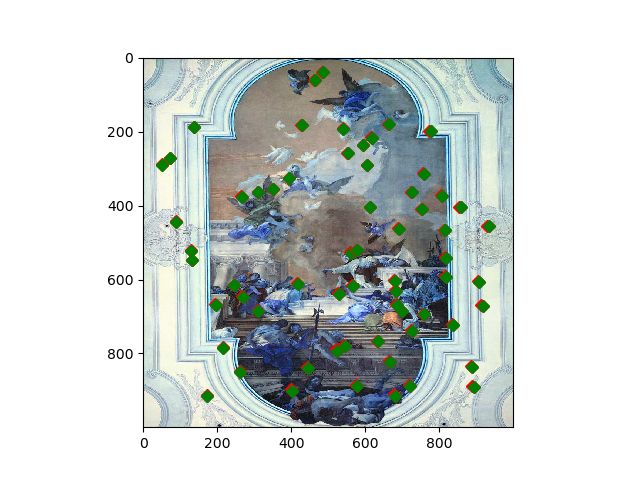

Benchmark de la fresque 5:
Moyenne de distance:.............1.8766616885859568
Ecart type des distances :.......1.7053272139368754
Moyenne de placement trouvé:.....0.63



Moyenne de distance rect:........0.40146527853492
Ecart type des distances rect :..0.42359690813919143
Moyenne de placement trouvé:.....0.63
Distance Min - Max:..............0.0 - 5.0


In [8]:
results_filename = './results_bench/results_SLLShift_8_f5_03-11_18-36_E3_0120'
with open(results_filename,'r') as f:
    res = json.loads(f.readline())

m = res['matched']
d = res['distances']
p = res['positions']
v = res['vt']
npos = []

# Supprime les valeurs abhérentes
#for i in range(len(m)):
#    if m[i] == 1 and d[i] > 50:
#        m[i] = 0


for i in range(len(m)):
    if m[i] == 1:
        #print(p[i])
        pos = rectification(p[i],0.003731,-0.0025)
        #print("-> {}".format(pos))
        npos.append(pos)
    else:
        npos.append(-1)
        

d = [np.linalg.norm((v[i][0]-p[i][0],v[i][1]-p[i][1])) if m[i]==1 else 0 for i in range(len(v))]
nd = [np.linalg.norm((v[i][0]-npos[i][0],v[i][1]-npos[i][1])) if m[i]==1 else 0 for i in range(len(v))]



carte(m,p,v,res['meta'])

#correlation(m,p,v,d,res['meta'])

#distance_vecteur(m,p,v)

#correl_pos_err(m,p,d)

#dist_dist(m,p,d)
#dist_dist(m,npos,nd)

#barchart_dif(d,nd)


# Affiche quelques stats:
print("Benchmark de la fresque {}:".format(res['meta']['fresque_id']))
print("Moyenne de distance:.............{}".format(np.average(d)))
print("Ecart type des distances :.......{}".format(np.std(d)))
print("Moyenne de placement trouvé:.....{}".format(np.average(m)))
print("\n\n")
print("Moyenne de distance rect:........{}".format(np.average(nd)))
print("Ecart type des distances rect :..{}".format(np.std(nd)))
print("Moyenne de placement trouvé:.....{}".format(np.average(m)))
print("Distance Min - Max:..............{:.3} - {:.3}".format(np.min(d),np.max(d)))

5 5


<IPython.core.display.Javascript object>


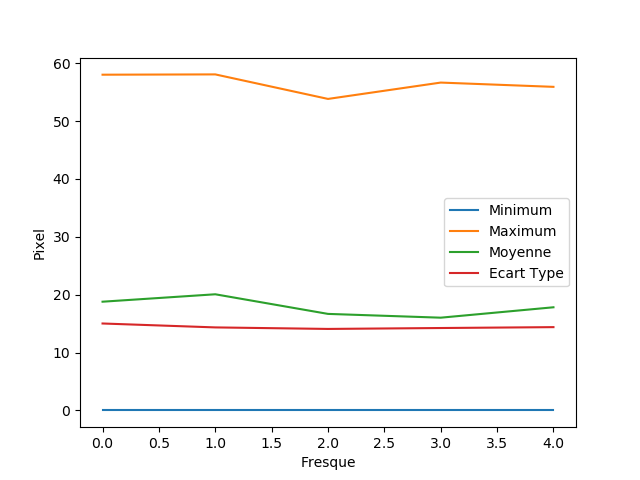

In [38]:
results_filenames = './results_bench/results_bench_f*_*0001'
results_paths = glob(results_filenames)
ab = np.arange(0,len(results_paths),1)


maxi,mini,moyennes,ets = [], [], [], []

for path in results_paths:
    with open(path,'r') as f:
        res = json.loads(f.readline())
    
    m = res['matched']
    p = res['positions']
    v = res['vt']
    d = [np.linalg.norm((v[i][0]-p[i][0],v[i][1]-p[i][1])) if m[i]==1 else 0 for i in range(len(v))]
    maxi.append(np.max(d))
    mini.append(np.min(d))
    moyennes.append(np.average(d))
    ets.append(np.std(d))

    
print(len(ab),len(maxi))
fig,ax = plt.subplots(1,1)
ax.plot(ab,mini,label="Minimum")
ax.plot(ab,maxi,label="Maximum")
ax.plot(ab,moyennes,label="Moyenne")
ax.plot(ab,ets,label="Ecart Type")

ax.legend(loc='best')
ax.set_xlabel("Fresque")
ax.set_ylabel("Pixel")

plt.show()

In [31]:
results_filenames = './results_bench/results_random_color__f*_*_0008'
result_filename = './results_bench/results_random_color__f{}_*_0008'
results_paths = glob(results_filenames)

fresque_ids = []
ets = []
dists = []
asso = []


print(len(results_paths))

for fresque_id in range(len(results_paths)):
    path = result_filename.format(fresque_id)
    
    with open(path,'r') as f:
        res = json.loads(f.readline())
        
    m = res['matched']
    d = res['distances']
    p = res['positions']
    v = res['vt']
    npos = []

    for i in range(len(m)):
        if m[i] == 1:
            #print(p[i])
            pos = rectification(p[i],0.0073,0.2225)
            #print("-> {}".format(pos))
            npos.append(pos)
        else:
            npos.append(-1)
            
    fresque_ids.append(fresque_id)
    ets.append(round(np.std(nd),3))
    dists.append(round(np.average(nd),3))
    asso.append(np.average(m))


6


FileNotFoundError: [Errno 2] No such file or directory: './results_bench/results_random_color__f0_*_0008'